# Preserving Heritage: Enhancing Tourism with AI
## **PART 1. Predict the category of a structure** 

There are centuries old historical structures that preserve a country's and community's 
history for future generations and promote tourism opportunities. 
To improve tourism, a government agency decides to use advanced machine learning 
techniques to monitor the condition of these historical structures and report if any of 
them need maintenance. 
Also, understanding customers (tourists) and their expectations is critical for effective 
marketing and promotion of tourism. A recommendation engine is an excellent way to 
supplement existing marketing outreach. 

Develop an intelligent and automated AI model using TensorFlow that can predict the 
category of a structure in an image. 

### Import libraries

In [130]:
import os
import zipfile
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

### Unzip the dataset

In [133]:
zip_path = r"Datasets/Capstone 2/Part 1/dataset_hist_structures 2.zip"
extract_path = r"C:\hist_structures"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")
print("Extracted to:", extract_path)

Dataset unzipped successfully!
Extracted to: C:\hist_structures


### Plot sample images from each class or category

Detected classes: ['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle', 'stained_glass', 'test', 'train', 'vault']


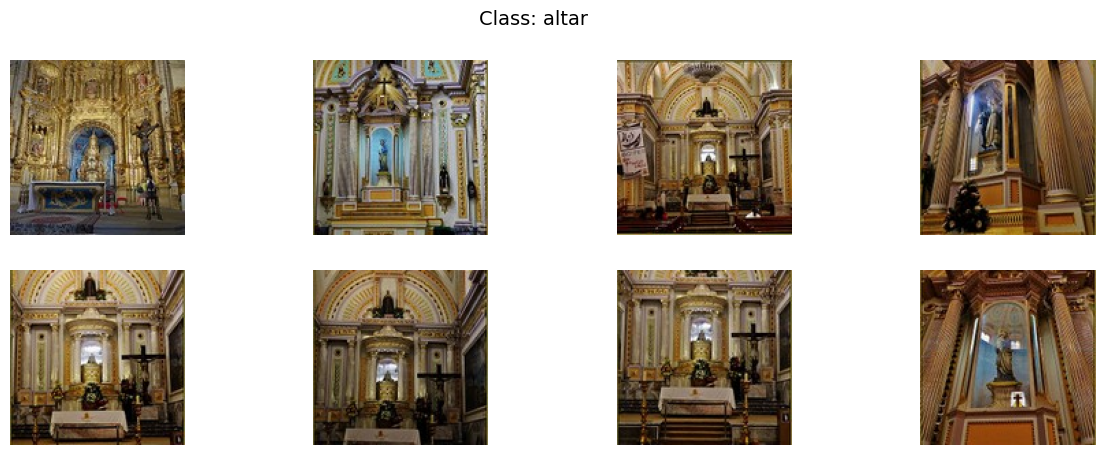

Skipping unreadable image: C:\hist_structures\dataset_hist_structures 2\dataset_hist_structures\Stuctures_Dataset\apse\1024px-Iglesia_de_Santiago_de_Mens_(┬ábside).jpg


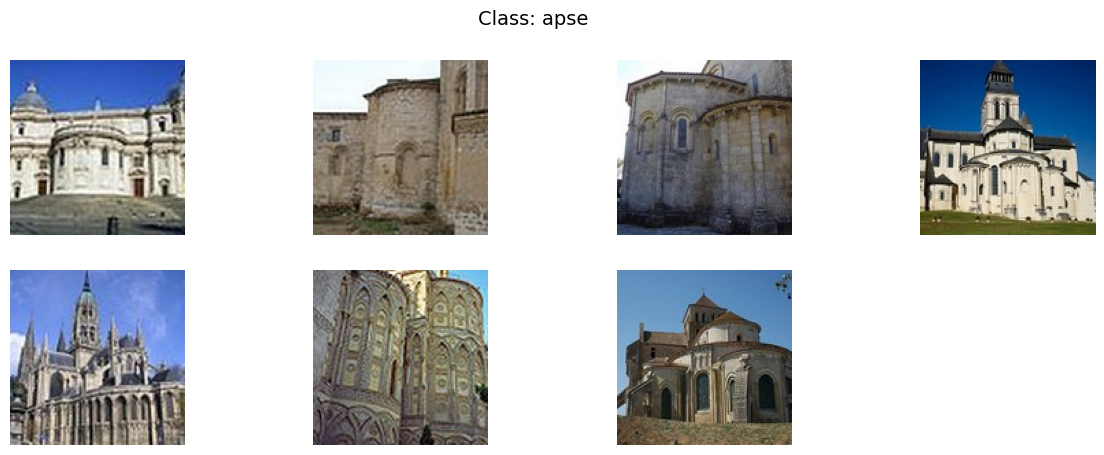

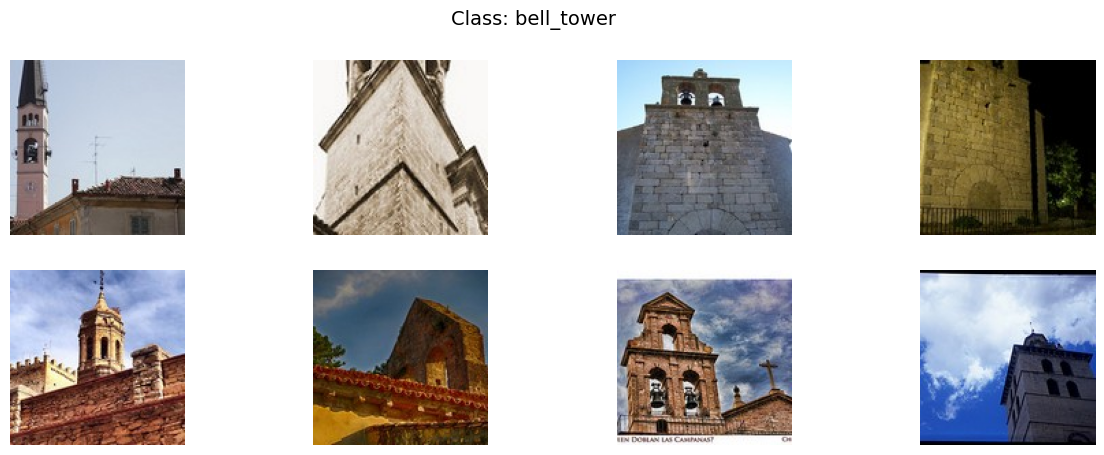

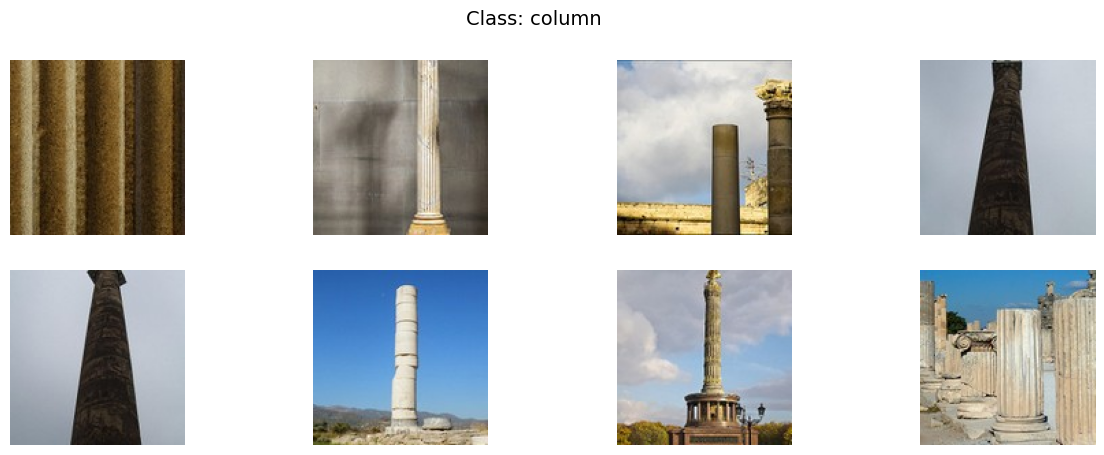

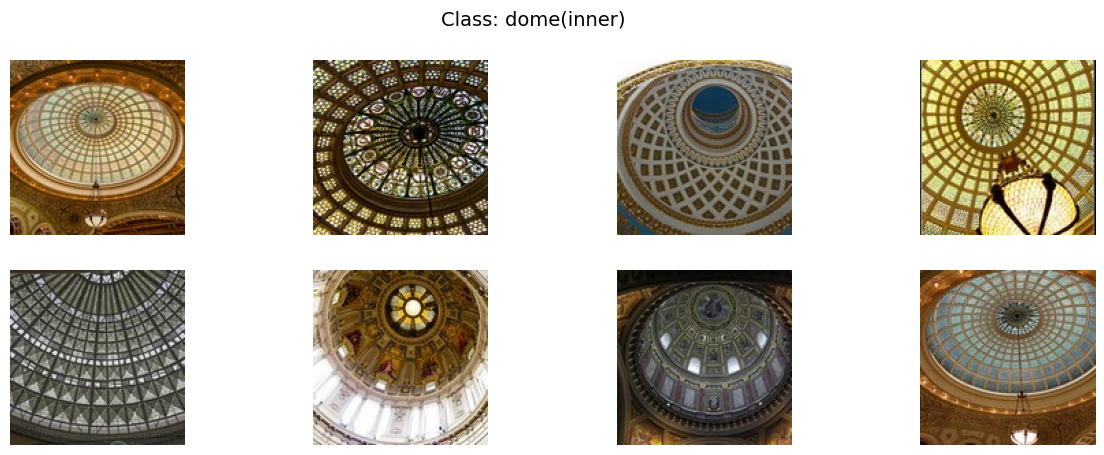

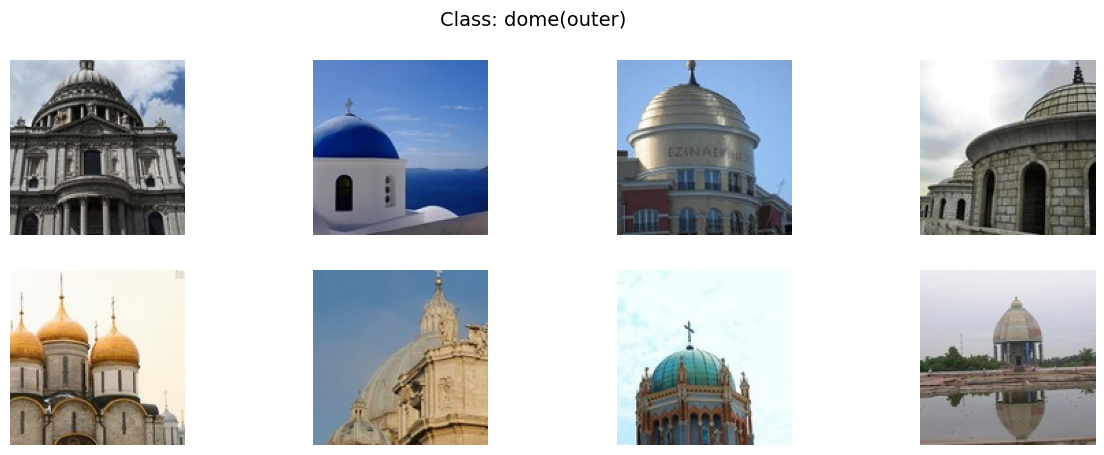

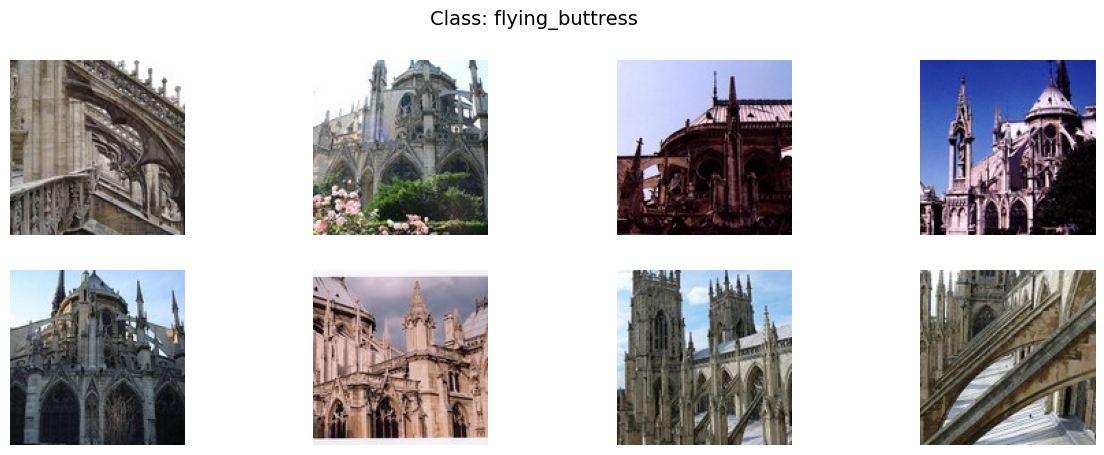

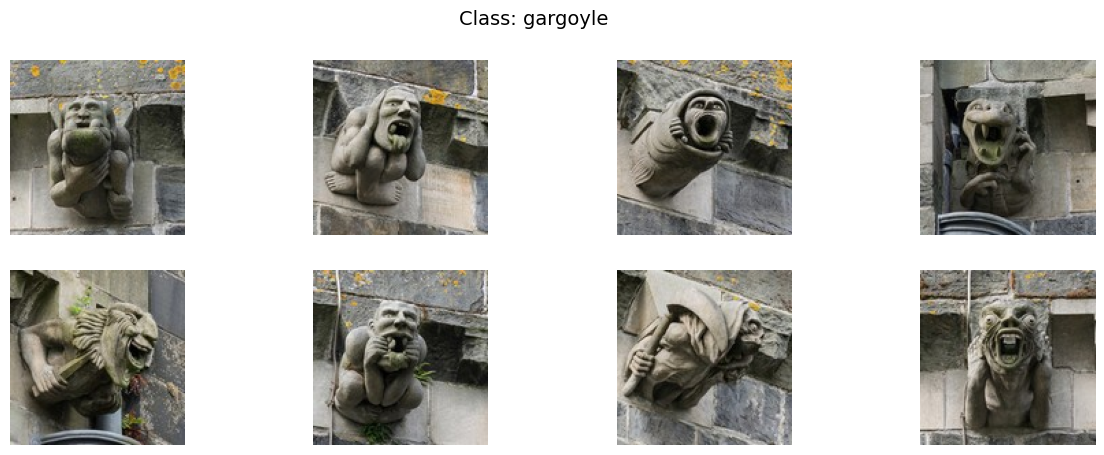

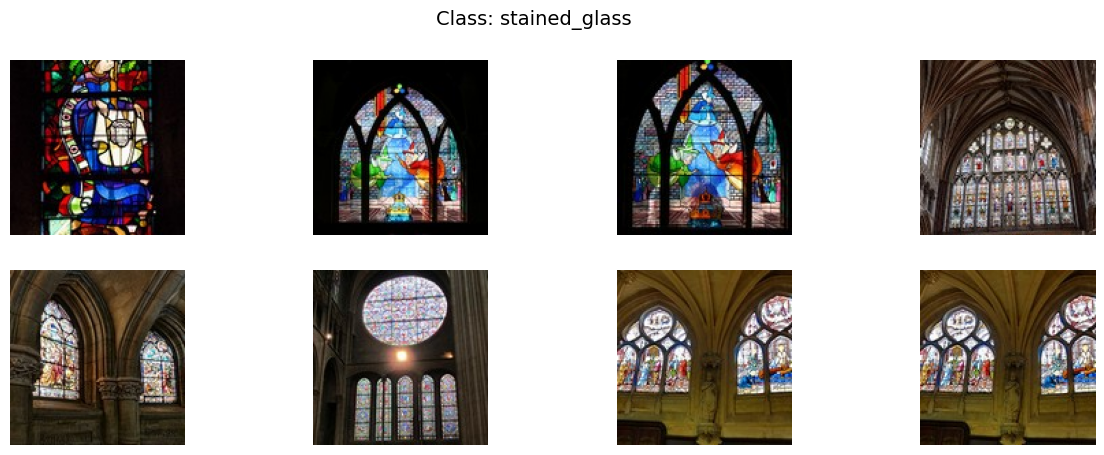

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

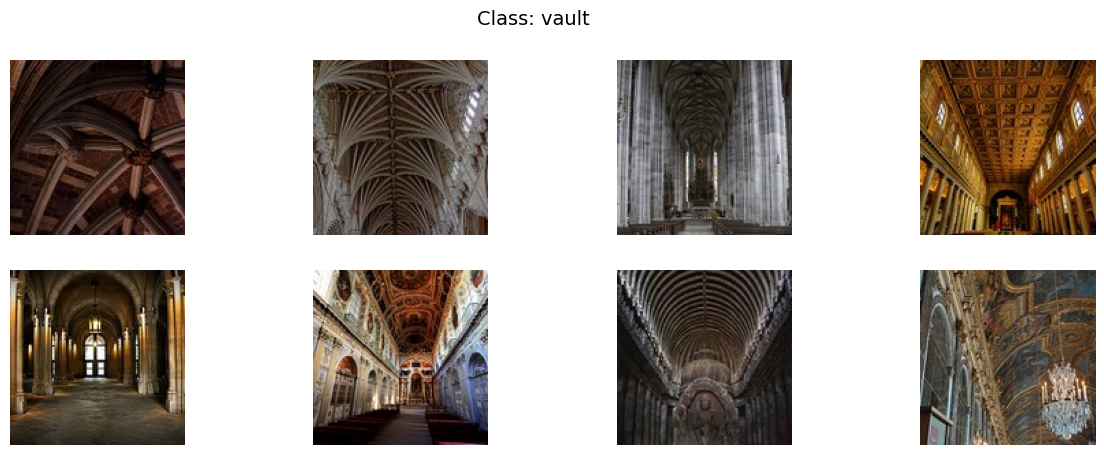

In [136]:
def visualize_class_samples(root_dir, class_list, samples_per_class=8):
    """
    Displays a fixed number of sample images for each class
    to allow manual inspection of the dataset.
    """

    for class_name in class_list:
        class_dir = os.path.join(root_dir, class_name)

        # Collect only valid image files
        image_files = [
            file for file in os.listdir(class_dir)
            if file.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        # Select limited number of images
        image_files = image_files[:samples_per_class]

        # Create a figure for the current class
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Class: {class_name}", fontsize=14)

        for idx, image_name in enumerate(image_files):
            image_path = os.path.join(class_dir, image_name)

            # Read image using OpenCV
            image = cv2.imread(image_path)

            # Skip corrupted or unreadable images
            if image is None:
                print(f"Skipping unreadable image: {image_path}")
                continue

            # Convert BGR (OpenCV default) to RGB for Matplotlib
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Plot image
            plt.subplot(2, samples_per_class // 2, idx + 1)
            plt.imshow(image)
            plt.axis("off")

        plt.show()


# ===============================
# Dataset path configuration
# ===============================
data_dir = os.path.join(
    extract_path,
    "dataset_hist_structures 2",
    "dataset_hist_structures",
    "Stuctures_Dataset"
)

# Identify class folders dynamically
class_names = [
    folder for folder in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, folder))
]

print("Detected classes:", class_names)

# ===============================
# Visualize samples
# ===============================
visualize_class_samples(data_dir, class_names, samples_per_class=8)

### Select an CNN architecture of your choice to train the CV model.
Configure the architecture for transfer learning, set up a TensorFlow environment for the selected
backbone architecture, and load pre-trained weights

VGG16 is selected in this project to capture high quality and fine grained visual details present in historical structure images. The architecture uses deep stacks of standard convolution layers with small receptive fields, which are effective in learning detailed texture, edge, and shape information.

Historical structures often contain intricate architectural elements such as carvings, domes, arches, and stained glass patterns. VGG16 is well suited for such tasks because its depth enables hierarchical feature extraction, from low level edges to high level structural patterns.

Although VGG16 has a high number of parameters, transfer learning is applied by using pre trained ImageNet weights and freezing most of the convolutional layers. This significantly reduces overfitting while still benefiting from the rich feature representations learned by the network.

In [141]:
def build_vgg16_classifier(image_shape=(224, 224, 3), total_classes=1):
    # Load the pre trained VGG16 convolutional base
    vgg_backbone = VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=image_shape
    )

    # Freeze all convolution layers to preserve learned features
    for layer in vgg_backbone.layers:
        layer.trainable = False

    # Construct the classification model
    classifier = models.Sequential()
    classifier.add(vgg_backbone)
    classifier.add(layers.Flatten())
    classifier.add(layers.Dense(256, activation="relu"))
    classifier.add(layers.Dropout(0.5))
    classifier.add(layers.Dense(total_classes, activation="softmax"))

    # Compile the model
    classifier.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return classifier


# ===============================
# Create the model
# ===============================
model = build_vgg16_classifier(
    image_shape=(224, 224, 3),
    total_classes=len(categories)
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 12)                  │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,140,556 (80.64 MB)

 Trainable params: 6,425,868 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Define callback class to stop the training once validation accuracy reaches a certain number of your choice

In [144]:
class ValidationAccuracyStopper(callbacks.Callback):
    def __init__(self, target_accuracy=0.90):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        # Safety check in case logs are not available
        if logs is None:
            return

        current_val_acc = logs.get("val_accuracy")

        # Stop training if validation accuracy crosses the threshold
        if current_val_acc is not None and current_val_acc >= self.target_accuracy:
            print(
                f"\nTarget validation accuracy of "
                f"{self.target_accuracy * 100:.1f}% reached. Stopping training."
            )
            self.model.stop_training = True


# ===============================
# Callback initialization
# ===============================
desired_accuracy = 0.90
accuracy_callback = ValidationAccuracyStopper(target_accuracy=desired_accuracy)


### Setup the train or test dataset directories and review the number of image samples for the train and test datasets for each class

In [146]:
import os
import shutil
from sklearn.model_selection import train_test_split


def split_dataset_into_train_test(root_dir, split_ratio=0.2, seed=42):
    # Define destination directories
    train_path = os.path.join(root_dir, "train")
    test_path = os.path.join(root_dir, "test")

    # Create train and test directories if they do not exist
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # Iterate through each class folder
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)

        # Skip non-directory entries and already created folders
        if not os.path.isdir(class_dir) or class_name in ["train", "test"]:
            continue

        # Collect valid image files
        image_files = [
            img for img in os.listdir(class_dir)
            if img.lower().endswith((".jpg", ".jpeg", ".png"))
        ]

        # Skip empty class folders
        if len(image_files) == 0:
            print(f"Skipping empty class folder: {class_name}")
            continue

        # Split images into training and testing sets
        train_imgs, test_imgs = train_test_split(
            image_files,
            test_size=split_ratio,
            random_state=seed
        )

        # Create class subfolders inside train and test directories
        os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

        # Move training images
        for img in train_imgs:
            src = os.path.join(class_dir, img)
            dst = os.path.join(train_path, class_name, img)
            shutil.move(src, dst)

        # Move testing images
        for img in test_imgs:
            src = os.path.join(class_dir, img)
            dst = os.path.join(test_path, class_name, img)
            shutil.move(src, dst)

    print("Train and test dataset split completed successfully.")


# ===============================
# Execute the split
# ===============================
split_dataset_into_train_test(data_dir, split_ratio=0.2)


Train and test dataset split completed successfully.


In [44]:
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 8273 images belonging to 10 classes.
Found 2073 images belonging to 10 classes.


### Train the model without augmentation while continuously monitoring the validation accuracy

In [150]:
# Compile the neural network with Adam optimizer
# Categorical crossentropy is used for multi class classification
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Display the number of images used for training and validation
train_count = train_generator.samples
validation_count = test_generator.samples

print(f"Total training images: {train_count}")
print(f"Total validation images: {validation_count}")


Total training images: 8273
Total validation images: 2073


In [152]:
no_classes = len(train_generator.class_indices)

In [154]:
print("Training classes:", train_generator.class_indices)
print("Validation classes:", test_generator.class_indices)
print('Number of classes:', no_classes)

Training classes: {'altar': 0, 'apse': 1, 'bell_tower': 2, 'column': 3, 'dome(inner)': 4, 'dome(outer)': 5, 'flying_buttress': 6, 'gargoyle': 7, 'stained_glass': 8, 'vault': 9}
Validation classes: {'altar': 0, 'apse': 1, 'bell_tower': 2, 'column': 3, 'dome(inner)': 4, 'dome(outer)': 5, 'flying_buttress': 6, 'gargoyle': 7, 'stained_glass': 8, 'vault': 9}
Number of classes: 10


In [156]:
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D


def build_basic_cnn(input_dims=(224, 224, 3), num_output_classes=1):
    cnn_model = models.Sequential()

    # First convolution block
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_dims))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second convolution block
    cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third convolution block
    cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    # Reduce spatial dimensions using global average pooling
    cnn_model.add(GlobalAveragePooling2D())

    # Output layer for multi class classification
    cnn_model.add(Dense(num_output_classes, activation="softmax"))

    return cnn_model


# ===============================
# Create the model
# ===============================
model = build_basic_cnn(
    input_dims=(224, 224, 3),
    num_output_classes=no_classes
)

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,538 (369.29 KB)

 Trainable params: 94,538 (369.29 KB)

 Non-trainable params: 0 (0.00 B)

### Compile the model with the right set of parameters like optimizer, loss function, and metric

In [158]:
# Configure the model with Adam optimizer and categorical loss
# Accuracy is used as the evaluation metric
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model without data augmentation
# Validation performance is monitored using the test generator
training_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[accuracy_callback]
)


Epoch 1/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.2729 - loss: 1.9297 - val_accuracy: 0.3213 - val_loss: 1.7048
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 235s 907ms/step - accuracy: 0.3694 - loss: 1.6535 - val_accuracy: 0.3840 - val_loss: 1.6446
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 209s 804ms/step - accuracy: 0.4114 - loss: 1.5506 - val_accuracy: 0.4486 - val_loss: 1.4618
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 189s 731ms/step - accuracy: 0.4716 - loss: 1.4262 - val_accuracy: 0.5162 - val_loss: 1.3457
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 184s 712ms/step - accuracy: 0.5190 - loss: 1.3218 - val_accuracy: 0.5707 - val_loss: 1.2233
Epoch 6/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 185s 716ms/step - accuracy: 0.5435 - loss: 1.2598 - val_accuracy: 0.5654 - val_loss: 1.2035
Epoch 7/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 187s 724ms/step - accuracy: 0.5647 - loss: 1.2120 - val_accuracy: 0.6112 - val_loss: 1.1249
Epoch 8/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 186s 717ms/step - accuracy: 0.5953 - lo

### Train the model with augmentation and keep monitoring validation accuracy

In [159]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---------------------------------------
# Configure data augmentation for training
# ---------------------------------------
train_augmentation = ImageDataGenerator(
    rescale=1.0 / 255.0,          # Normalize pixel values
    rotation_range=40,            # Random rotations
    width_shift_range=0.2,        # Horizontal translations
    height_shift_range=0.2,       # Vertical translations
    shear_range=0.2,              # Shear transformations
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Flip images horizontally
    fill_mode="nearest"           # Fill missing pixels after transform
)

# Generate augmented training batches from directory
augmented_train_loader = train_augmentation.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# ---------------------------------------
# Train the model using augmented data
# ---------------------------------------
augmented_training_history = model.fit(
    augmented_train_loader,
    epochs=10,
    validation_data=test_generator,
    callbacks=[accuracy_callback]
)


Found 8417 images belonging to 10 classes.
Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 223s 846ms/step - accuracy: 0.4955 - loss: 1.4026 - val_accuracy: 0.6575 - val_loss: 1.0447
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 219s 828ms/step - accuracy: 0.5348 - loss: 1.2901 - val_accuracy: 0.6122 - val_loss: 1.0996
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 219s 828ms/step - accuracy: 0.5458 - loss: 1.2623 - val_accuracy: 0.6102 - val_loss: 1.1094
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 219s 829ms/step - accuracy: 0.5533 - loss: 1.2441 - val_accuracy: 0.6044 - val_loss: 1.2015
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 217s 821ms/step - accuracy: 0.5560 - loss: 1.2154 - val_accuracy: 0.6416 - val_loss: 1.0139
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 210s 796ms/step - accuracy: 0.5745 - loss: 1.1932 - val_accuracy: 0.6464 - val_loss: 1.0127
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 220s 833ms/step - accuracy: 0.5766 - loss: 1.1911 - val_accuracy: 0.6242 - val_loss: 1.1072
Epoch 8/10
264/264 ━━━━━━━━━━━━━━

### Visualize training and validation accuracy on the y-axis against each epoch on the x-axis to see if the model overfits after a certain epoch

In [160]:
def visualize_accuracy_curves(training_log, plot_title="Model Accuracy Over Epochs"):
    # Retrieve accuracy values from training history
    training_accuracy = training_log.history.get("accuracy", [])
    validation_accuracy = training_log.history.get("val_accuracy", [])

    # Create epoch index for x-axis
    epoch_indices = range(1, len(training_accuracy) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_indices, training_accuracy, label="Training Accuracy")
    plt.plot(epoch_indices, validation_accuracy, label="Validation Accuracy")
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracy")
    plt.title(plot_title)
    plt.legend()
    plt.show()

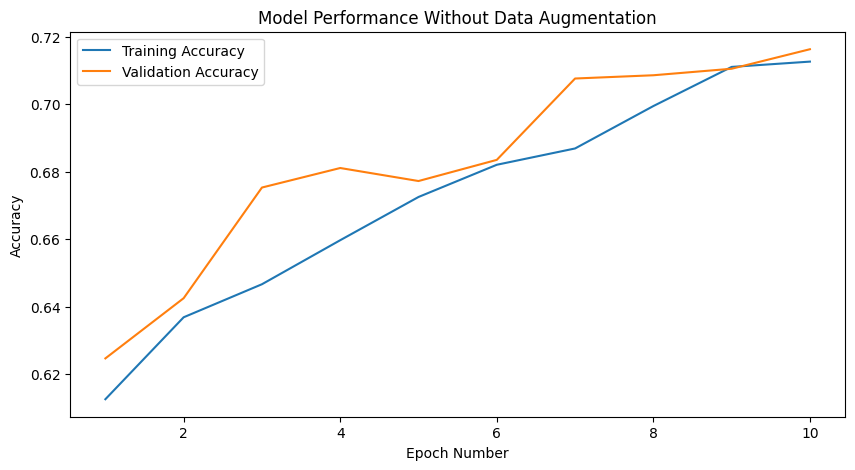

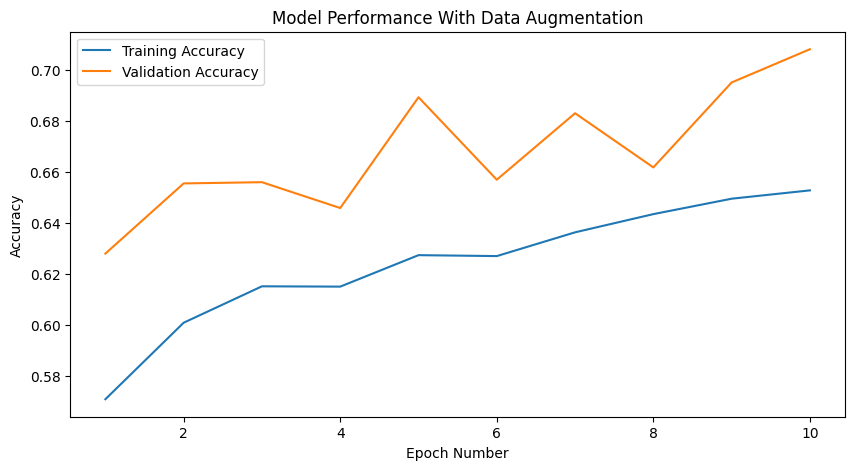

In [161]:
# Plot accuracy curves for training without data augmentation
visualize_accuracy_curves(
    training_log=history_no_aug,
    plot_title="Model Performance Without Data Augmentation"
)

# Plot accuracy curves for training with data augmentation
visualize_accuracy_curves(
    training_log=history_aug,
    plot_title="Model Performance With Data Augmentation"
)

### Visualise random image and its class

In [162]:
print("List of detected categories in the dataset:")

for category_name in categories:
    # Print each category on a new line for clarity
    print(category_name)

List of detected categories in the dataset:
altar
apse
bell_tower
column
dome(inner)
dome(outer)
flying_buttress
gargoyle
stained_glass
test
train
vault


In [163]:
def select_random_image(data_root):
    """
    Selects a random image from the dataset by first identifying
    valid class folders that contain image files.

    Parameters:
    data_root (str): Path to the dataset containing class subfolders

    Returns:
    tuple: (full_image_path, class_label)
    """

    eligible_classes = []

    # Identify class folders that contain at least one valid image
    for folder_name in os.listdir(data_root):
        folder_path = os.path.join(data_root, folder_name)

        if not os.path.isdir(folder_path):
            continue

        image_list = [
            file for file in os.listdir(folder_path)
            if file.lower().endswith((".jpg", ".jpeg", ".png"))
        ]

        if image_list:
            eligible_classes.append(folder_name)

    # Ensure at least one valid class is available
    if not eligible_classes:
        raise RuntimeError("Dataset does not contain any valid image classes")

    # Randomly choose a class
    chosen_class = random.choice(eligible_classes)
    chosen_class_path = os.path.join(data_root, chosen_class)

    # Randomly choose an image from the selected class
    class_images = [
        file for file in os.listdir(chosen_class_path)
        if file.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    selected_image = random.choice(class_images)
    selected_image_path = os.path.join(chosen_class_path, selected_image)

    return selected_image_path, chosen_class

#### Plot random training image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


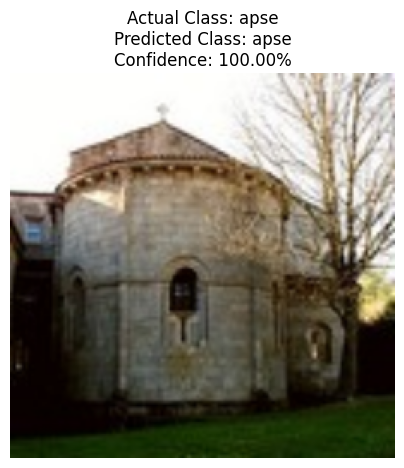

In [176]:
# ---------------------------------------
# Select a random training image
# ---------------------------------------
image_file, actual_label = select_random_image(train_dir)

# ---------------------------------------
# Read and prepare the image for inference
# ---------------------------------------
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))

# Add batch dimension for model prediction
image_batch = np.expand_dims(image, axis=0)

# ---------------------------------------
# Load class labels from dataset directory
# ---------------------------------------
label_names = sorted([
    folder for folder in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, folder))
])

# ---------------------------------------
# Perform prediction
# ---------------------------------------
prediction_scores = model.predict(image_batch)
predicted_label = label_names[np.argmax(prediction_scores)]
prediction_confidence = np.max(prediction_scores) * 100

# ---------------------------------------
# Display image and prediction details
# ---------------------------------------
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.title(
    f"Actual Class: {actual_label}\n"
    f"Predicted Class: {predicted_label}\n"
    f"Confidence: {prediction_confidence:.2f}%"
)
plt.show()

#### Plot test image


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


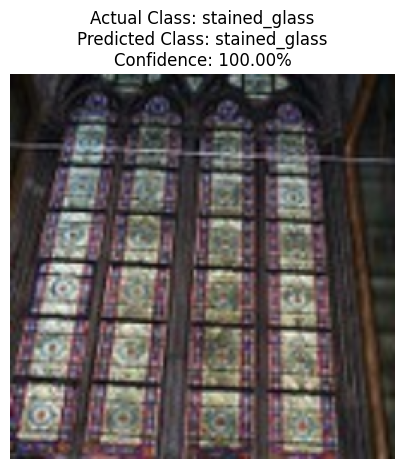

In [178]:
# ---------------------------------------
# Select a random testing image safely
# ---------------------------------------
image_file, actual_label = select_random_image(test_dir)

# ---------------------------------------
# Read and prepare the image for inference
# ---------------------------------------
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))

# Add batch dimension for model prediction
image_batch = np.expand_dims(image, axis=0)

# ---------------------------------------
# Load class labels from dataset directory
# ---------------------------------------
label_names = sorted([
    folder for folder in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, folder))
])

# ---------------------------------------
# Perform prediction
# ---------------------------------------
prediction_scores = model.predict(image_batch)
predicted_label = label_names[np.argmax(prediction_scores)]
prediction_confidence = np.max(prediction_scores) * 100

# ---------------------------------------
# Display image and prediction details
# ---------------------------------------
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.title(
    f"Actual Class: {actual_label}\n"
    f"Predicted Class: {predicted_label}\n"
    f"Confidence: {prediction_confidence:.2f}%"
)
plt.show()

### CONCLUSION
The trained image classification model was evaluated through random image prediction and visual inspection, confirming that it can accurately recognize different categories of historical structures. By learning distinctive architectural features, the model demonstrates strong potential for real-world heritage analysis beyond standard accuracy metrics.

From a broader perspective, this AI-driven approach has significant implications for heritage preservation and tourism enhancement. Automated classification of historical structures can assist government agencies and cultural organizations in monitoring monument conditions, identifying structures that require maintenance, and prioritizing conservation efforts. Additionally, such models can be integrated into digital tourism platforms to provide intelligent recommendations, improve visitor engagement, and deliver educational content tailored to specific heritage sites. Overall, the use of AI contributes to sustainable heritage management while enriching tourist experiences through data-driven insights.

## **PART 2. Perform exploratory data analysis and develop a recommendation engine** 
Perform exploratory data analysis 
and develop a recommendation engine that will help tourists visit their places of interest. 

### Load dataset and perform preliminary inspections such as 
- Check for missing values and duplicates
- Remove any anomalies found in the data

In [417]:
import numpy as np
import pandas as pd
# Load datasets
users_df = pd.read_csv("Datasets/Capstone 2/Part 2/user.csv")
tourism_df = pd.read_excel("Datasets/Capstone 2/Part 2/tourism_with_id.xlsx")
ratings_df = pd.read_csv("Datasets/Capstone 2/Part 2/tourism_rating.csv")

In [419]:
print("Users Dataset Info")
users_df.info()

print("\nTourism Dataset Info")
tourism_df.info()

print("\nRatings Dataset Info")
ratings_df.info()

Users Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB

Tourism Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    fl

In [421]:
users_df.head()

User_Id                   Location  Age
0        1      Semarang, Jawa Tengah   20
1        2         Bekasi, Jawa Barat   21
2        3        Cirebon, Jawa Barat   23
3        4         Bekasi, Jawa Barat   21
4        5  Lampung, Sumatera Selatan   20

In [423]:
tourism_df.head()

Place_Id                         Place_Name  \
0         1                   Monumen Nasional   
1         2                           Kota Tua   
2         3                      Dunia Fantasi   
3         4  Taman Mini Indonesia Indah (TMII)   
4         5           Atlantis Water Adventure   

                                         Description       Category     City  \
0  Monumen Nasional atau yang populer disingkat d...         Budaya  Jakarta   
1  Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya  Jakarta   
2  Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan  Jakarta   
3  Taman Mini Indonesia Indah merupakan suatu kaw...  Taman Hiburan  Jakarta   
4  Atlantis Water Adventure atau dikenal dengan A...  Taman Hiburan  Jakarta   

    Price  Rating  Time_Minutes  \
0   20000     4.6          15.0   
1       0     4.6          90.0   
2  270000     4.6         360.0   
3   10000     4.5           NaN   
4   94000     4.5          60.0   

                                        Coordinate       Lat        Long  \
0          {'lat': -6.1753924, 'lng': 106.8271528} -6.175392  106.827153   
1  {'lat': -6.137644799999999, 'lng': 106.8171245} -6.137645  106.817125   
2  {'lat': -6.125312399999999, 'lng': 106.8335377} -6.125312  106.833538   
3  {'lat': -6.302445899999999, 'lng': 106.8951559} -6.302446  106.895156   
4             {'lat': -6.12419, 'lng': 106.839134} -6.124190  106.839134   

   Unnamed: 11  Unnamed: 12  
0          NaN            1  
1          NaN            2  
2          NaN            3  
3          NaN            4  
4          NaN            5

In [425]:
tourism_df  = tourism_df.loc[:, ~tourism_df.columns.str.contains("^Unnamed")]
tourism_df.head()

Place_Id                         Place_Name  \
0         1                   Monumen Nasional   
1         2                           Kota Tua   
2         3                      Dunia Fantasi   
3         4  Taman Mini Indonesia Indah (TMII)   
4         5           Atlantis Water Adventure   

                                         Description       Category     City  \
0  Monumen Nasional atau yang populer disingkat d...         Budaya  Jakarta   
1  Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya  Jakarta   
2  Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan  Jakarta   
3  Taman Mini Indonesia Indah merupakan suatu kaw...  Taman Hiburan  Jakarta   
4  Atlantis Water Adventure atau dikenal dengan A...  Taman Hiburan  Jakarta   

    Price  Rating  Time_Minutes  \
0   20000     4.6          15.0   
1       0     4.6          90.0   
2  270000     4.6         360.0   
3   10000     4.5           NaN   
4   94000     4.5          60.0   

                                        Coordinate       Lat        Long  
0          {'lat': -6.1753924, 'lng': 106.8271528} -6.175392  106.827153  
1  {'lat': -6.137644799999999, 'lng': 106.8171245} -6.137645  106.817125  
2  {'lat': -6.125312399999999, 'lng': 106.8335377} -6.125312  106.833538  
3  {'lat': -6.302445899999999, 'lng': 106.8951559} -6.302446  106.895156  
4             {'lat': -6.12419, 'lng': 106.839134} -6.124190  106.839134

In [427]:
ratings_df.head()

User_Id  Place_Id  Place_Ratings
0        1       179              3
1        1       344              2
2        1         5              5
3        1       373              3
4        1       101              4

In [429]:
# Print missing values
print("Missing values in Users dataset")
print(users_df.isnull().sum())

print("\nMissing values in Tourism dataset")
print(tourism_df.isnull().sum())

print("\nMissing values in Ratings dataset")
print(ratings_df.isnull().sum())


Missing values in Users dataset
User_Id     0
Location    0
Age         0
dtype: int64

Missing values in Tourism dataset
Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
dtype: int64

Missing values in Ratings dataset
User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64


### Exploratory data analysis
 Explore the user group that provides the tourism ratings by:
- Analyzing the age distribution of users visiting the places and rating them 
- Identifying the places where most of these users (tourists) are coming from

**Merge User Data with Ratings**

In [452]:
# Merge users with ratings on user identifier
user_ratings_df = ratings_df.merge(
    users_df,
    left_on="User_Id",
    right_on="User_Id",
    how="inner"
)

user_ratings_df.head()

User_Id  Place_Id  Place_Ratings               Location  Age
0        1       179              3  Semarang, Jawa Tengah   20
1        1       344              2  Semarang, Jawa Tengah   20
2        1         5              5  Semarang, Jawa Tengah   20
3        1       373              3  Semarang, Jawa Tengah   20
4        1       101              4  Semarang, Jawa Tengah   20

**Analyze age distribution**

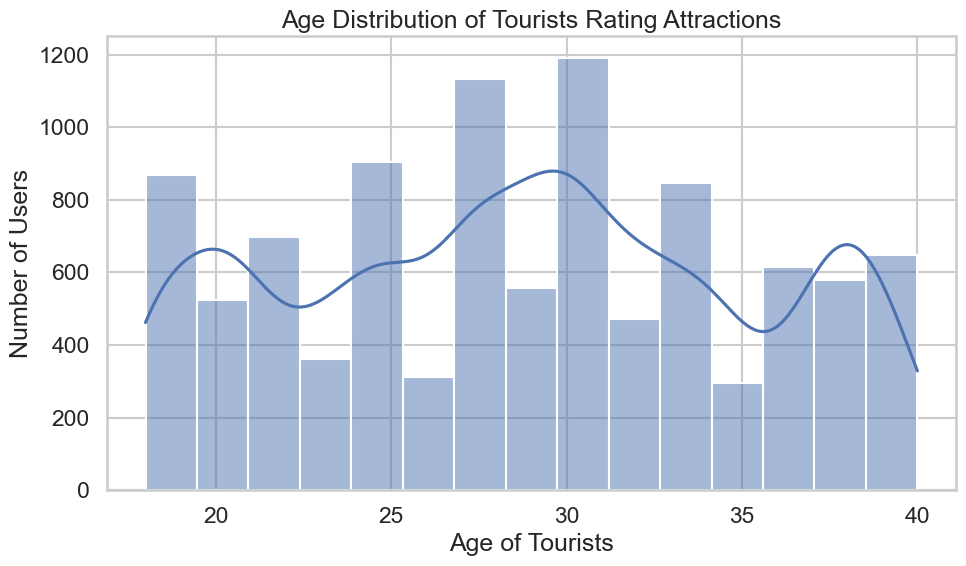

In [455]:
import seaborn as sns

# Set a clean visual theme
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(10, 6))

sns.histplot(
    user_ratings_df["Age"],
    bins=15,
    kde=True,
    color="#4C72B0"
)

plt.xlabel("Age of Tourists")
plt.ylabel("Number of Users")
plt.title("Age Distribution of Tourists Rating Attractions")

plt.tight_layout()
plt.show()

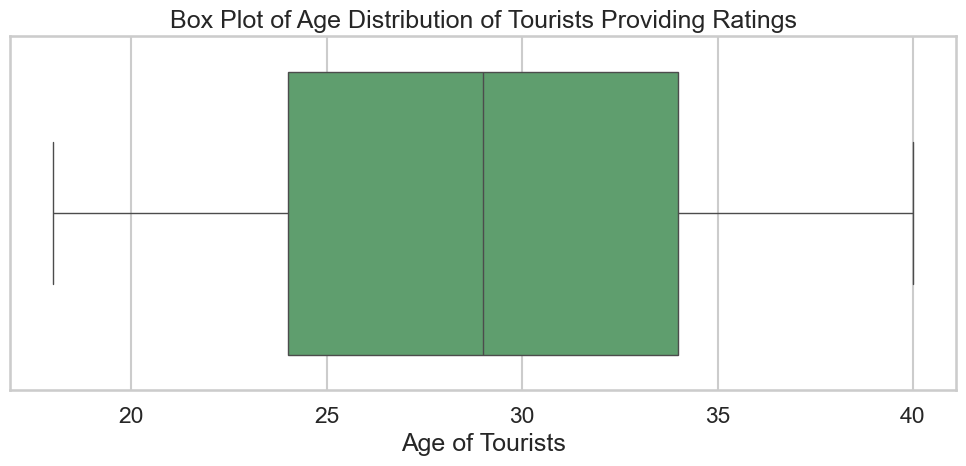

In [457]:
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(10, 5))
sns.boxplot(
    x=user_ratings_df["Age"],
    color="#55A868"
)

plt.xlabel("Age of Tourists")
plt.title("Box Plot of Age Distribution of Tourists Providing Ratings")

plt.tight_layout()
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14024\3767019910.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


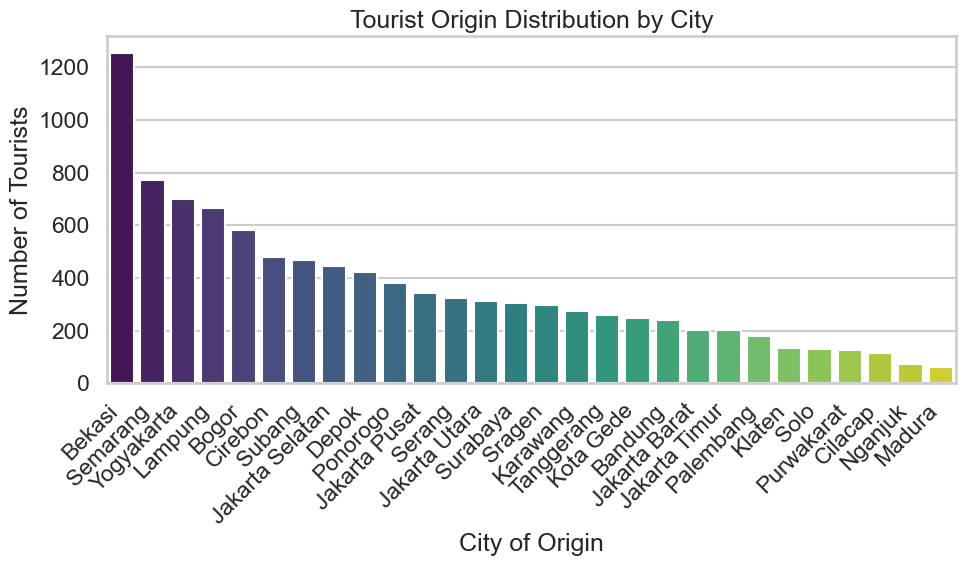

In [459]:
user_ratings_df['city'] = user_ratings_df.Location.apply(lambda x: x.split(",")[0])
location_counts = user_ratings_df["city"].value_counts()

plt.figure(figsize=(10, 6))

sns.barplot(
    x=location_counts.index,
    y=location_counts.values,
    palette="viridis"
)

plt.xlabel("City of Origin")
plt.ylabel("Number of Tourists")
plt.title("Tourist Origin Distribution by City")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14024\3945372761.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


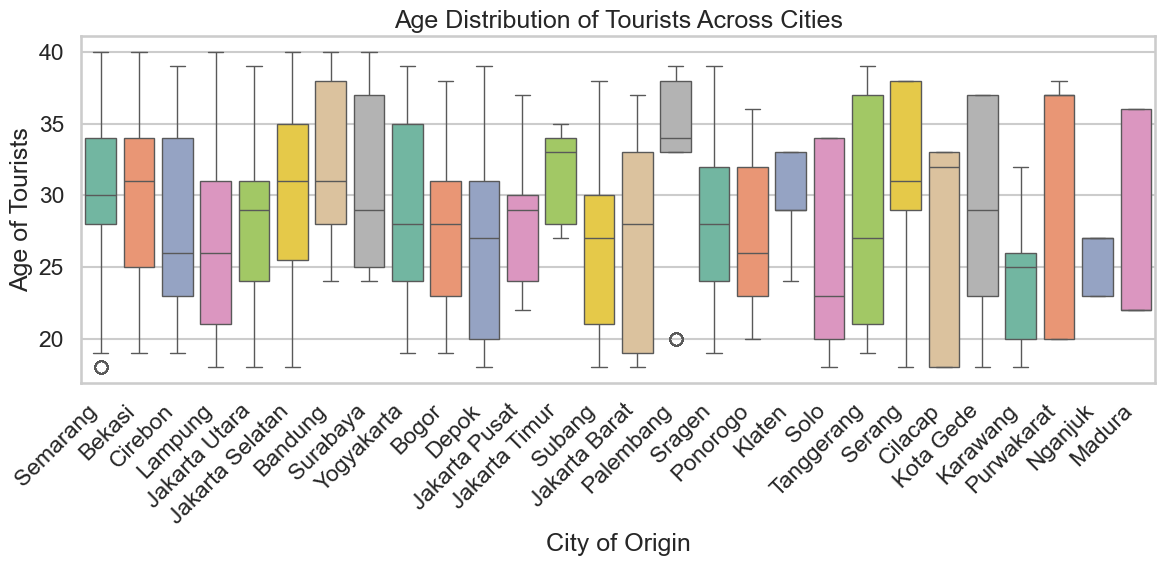

In [461]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    x="city",
    y="Age",
    data=user_ratings_df,
    palette="Set2"
)

plt.xlabel("City of Origin")
plt.ylabel("Age of Tourists")
plt.title("Age Distribution of Tourists Across Cities")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Explore the locations and categories of tourist spots.**
- What are the different categories of tourist spots?

In [463]:
# Unique categories
tourist_categories = tourism_df["Category"].unique()
print("Tourist spot categories:")
for cat in tourist_categories:
    print("-", cat)

Tourist spot categories:
- Budaya
- Taman Hiburan
- Cagar Alam
- Bahari
- Pusat Perbelanjaan
- Tempat Ibadah


**Category Distribution**

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14024\3420602738.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


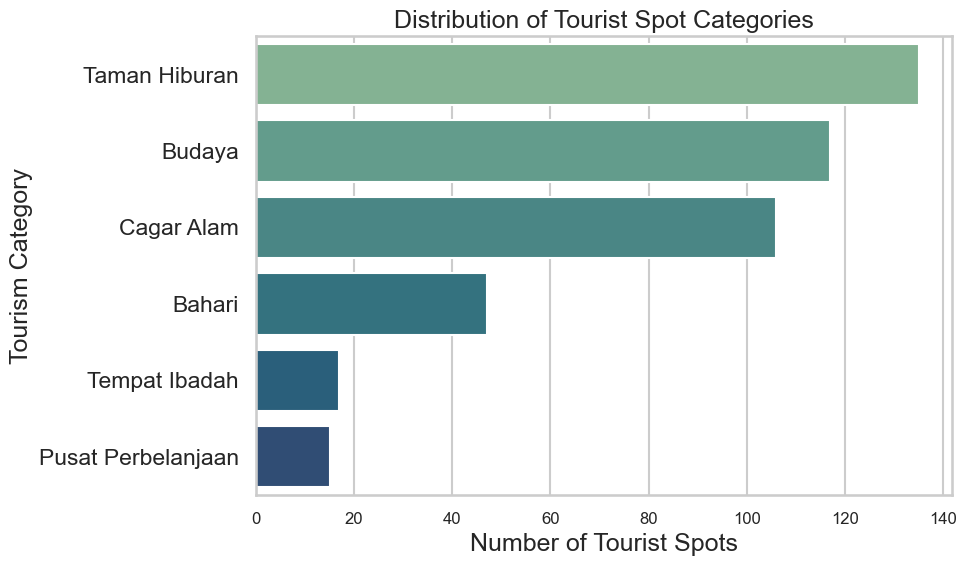

In [474]:
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(10, 6))

category_counts = tourism_df["Category"].value_counts()

sns.barplot(
    y=category_counts.index,
    x=category_counts.values,
    palette="crest"
)

plt.xlabel("Number of Tourist Spots")
plt.ylabel("Tourism Category")
plt.xticks(size = 12)
plt.title("Distribution of Tourist Spot Categories")

plt.tight_layout()
plt.show()

In [476]:
city_category_counts = (
    tourism_df
    .groupby(["City", "Category"])
    .size()
    .reset_index(name="Count")
)
cities = city_category_counts["City"].unique()


- What kind of tourism each location is most famous or suitable for?


C:\Users\lenovo\AppData\Local\Temp\ipykernel_14024\810521922.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_14024\810521922.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_14024\810521922.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_14024\810521922.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

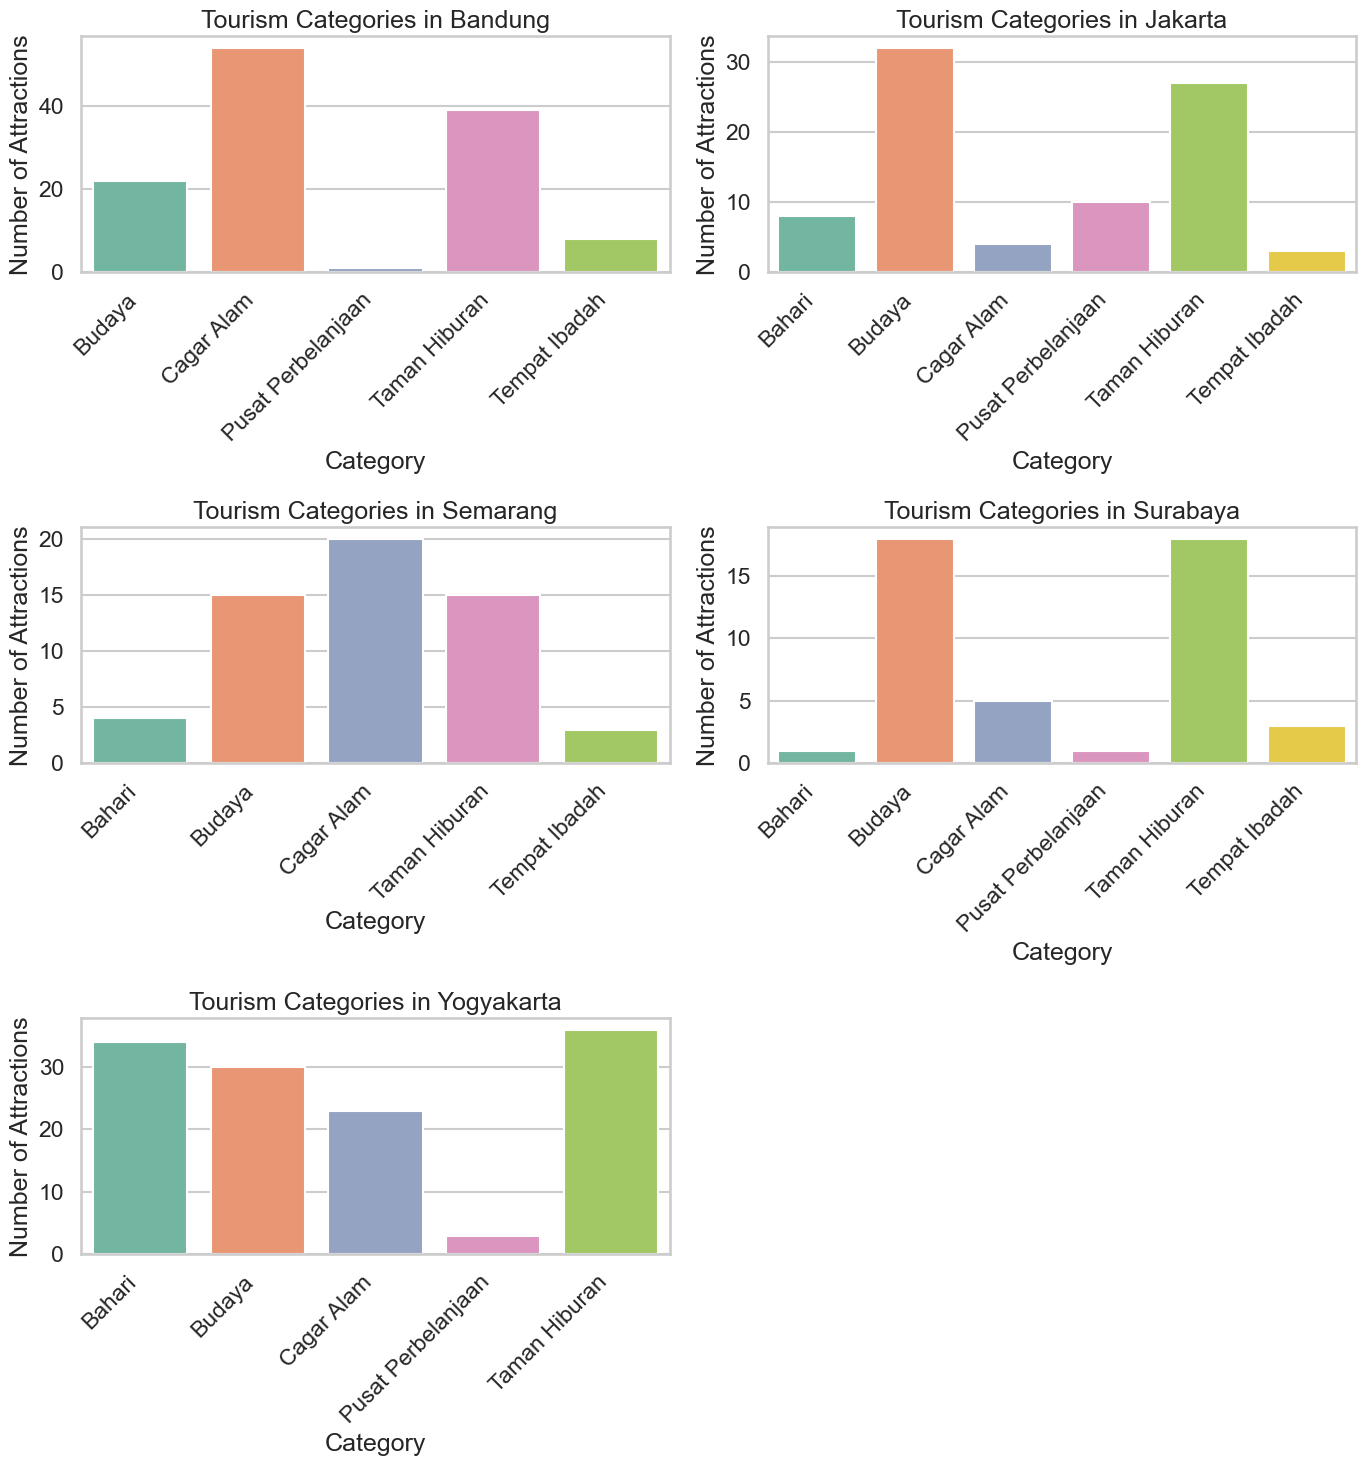

In [478]:
sns.set(style="whitegrid", context="talk")

num_cities = len(cities)
cols = 2
rows = (num_cities + cols - 1) // cols

plt.figure(figsize=(14, rows * 5))

for idx, city in enumerate(cities, start=1):
    plt.subplot(rows, cols, idx)

    city_data = city_category_counts[
        city_category_counts["City"] == city
    ]

    sns.barplot(
        data=city_data,
        x="Category",
        y="Count",
        palette="Set2"
    )

    plt.title(f"Tourism Categories in {city}")
    plt.xlabel("Category")
    plt.ylabel("Number of Attractions")
    plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


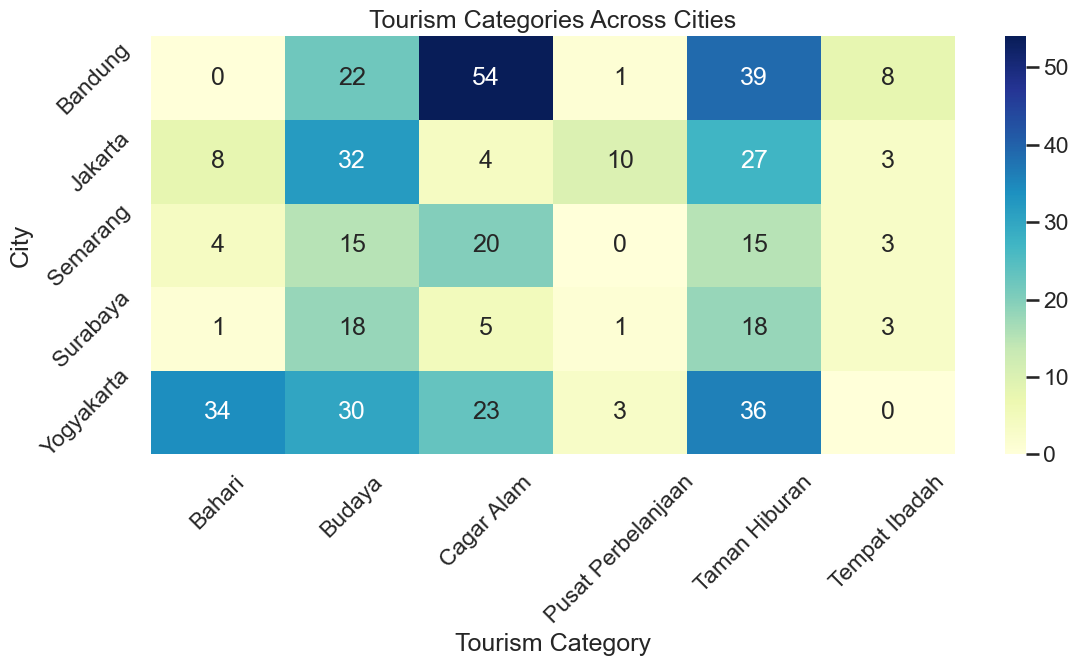

In [521]:
pivot_table = city_category_counts.pivot(
    index="City",
    columns="Category",
    values="Count"
).fillna(0)

plt.figure(figsize=(12, 7))

sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu"
)

plt.title("Tourism Categories Across Cities")
plt.xlabel("Tourism Category")
plt.xticks(rotation=45)
plt.ylabel("City")
plt.yticks(rotation=45)

plt.tight_layout()
plt.show()


- Which city would be the best for a nature enthusiast to visit?

In [513]:
tourism_df.Category.unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah'], dtype=object)

In [515]:
# Define nature-related categories explicitly
nature_categories = ["Cagar alam", "Bahari"]

# Filter dataset for nature tourism
nature_spots = tourism_df[
    tourism_df["Category"].isin(nature_categories)
]

nature_spots.head()

Place_Id        Place_Name  \
8          9  Pelabuhan Marina   
9         10      Pulau Tidung   
10        11    Pulau Bidadari   
11        12        Pulau Pari   
12        13     Pulau Pramuka   

                                          Description Category     City  \
8   Pelabuhan Marina Ancol berada di kawasan Taman...   Bahari  Jakarta   
9   Pulau Tidung adalah salah satu kelurahan di ke...   Bahari  Jakarta   
10  Pulau Bidadari merupakan salah satu resor di K...   Bahari  Jakarta   
11  Pulau Pari adalah sebuah pulau yang terletak d...   Bahari  Jakarta   
12  Pulau Pramuka merupakan salah satu pulau yang ...   Bahari  Jakarta   

     Price  Rating  Time_Minutes  \
8   175000     4.4           NaN   
9   150000     4.5           NaN   
10    5000     4.6           NaN   
11  150000     4.0           NaN   
12    5000     4.2           NaN   

                                         Coordinate       Lat        Long  
8               {'lat': 1.07888, 'lng': 103.931398}  1.078880  103.931398  
9   {'lat': -5.803205300000001, 'lng': 106.5237907} -5.803205  106.523791  
10   {'lat': -6.035832999999999, 'lng': 106.746944} -6.035833  106.746944  
11          {'lat': -5.9074328, 'lng': 106.5863989} -5.907433  106.586399  
12           {'lat': -5.745962, 'lng': 106.6136577} -5.745962  106.613658

In [517]:
nature_city_counts = nature_spots["City"].value_counts()

nature_city_counts

City
Yogyakarta    34
Jakarta        8
Semarang       4
Surabaya       1
Name: count, dtype: int64

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14024\3160914389.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


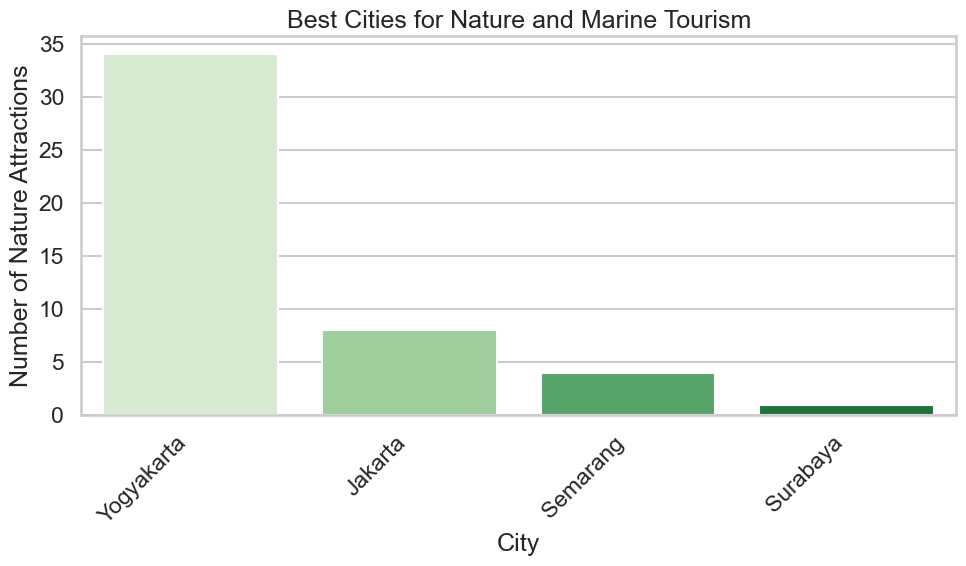

In [504]:
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(10, 6))

sns.barplot(
    x=nature_city_counts.index,
    y=nature_city_counts.values,
    palette="Greens"
)

plt.xlabel("City")
plt.ylabel("Number of Nature Attractions")
plt.title("Best Cities for Nature and Marine Tourism")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [506]:
best_nature_city = nature_city_counts.idxmax()
print("Best city for a nature enthusiast:", best_nature_city)

Best city for a nature enthusiast: Yogyakarta


Exploratory analysis of tourist locations revealed diverse categories of attractions across cities. Category distribution showed the dominant tourism types, while city-wise analysis highlighted each city’s tourism specialization. Nature-based attraction analysis identified the most suitable city for nature enthusiasts, enabling targeted and preference-aware tourism recommendations.
- Helps tourists choose destinations aligned with their interests

- Supports sustainable tourism by distributing visitor flow

- Assists policymakers in city-specific conservation planning

### Create a combined data with places and their user ratings

In [526]:
# Inspect columns to confirm join keys
print(tourism_df_clean.columns)
print(ratings_df_clean.columns)

Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price',
       'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long'],
      dtype='object')
Index(['User_Id', 'Place_Id', 'Place_Ratings'], dtype='object')


In [528]:
# Merge tourism places with ratings
tourism_ratings_df = ratings_df_clean.merge(
    tourism_df_clean,
    on="Place_Id",
    how="inner"
)

tourism_ratings_df.head()

User_Id  Place_Id  Place_Ratings                      Place_Name  \
0        1       179              3                 Candi Ratu Boko   
1        1         5              5        Atlantis Water Adventure   
2        1       373              3          Museum Kereta Ambarawa   
3        1       312              2  Taman Hutan Raya Ir. H. Juanda   
4        1        20              4           Museum Taman Prasasti   

                                         Description       Category  \
0  Situs Ratu Baka atau Candi Boko (Hanacaraka:Í¶...         Budaya   
1  Atlantis Water Adventure atau dikenal dengan A...  Taman Hiburan   
2  Museum Kereta Api Ambarawa (bahasa Inggris: In...         Budaya   
3  Taman Hutan Raya Ir. H. Djuanda (Tahura Djuand...     Cagar Alam   
4  Museum Taman Prasasti adalah sebuah museum cag...         Budaya   

         City  Price  Rating  Time_Minutes  \
0  Yogyakarta  75000     4.6          90.0   
1     Jakarta  94000     4.5          60.0   
2    Semarang  10000     4.5          60.0   
3     Bandung  11000     4.5          90.0   
4     Jakarta   2000     4.5          90.0   

                                        Coordinate       Lat        Long  
0          {'lat': -7.7705416, 'lng': 110.4894158} -7.770542  110.489416  
1             {'lat': -6.12419, 'lng': 106.839134} -6.124190  106.839134  
2  {'lat': -7.264598899999997, 'lng': 110.4046017} -7.264599  110.404602  
3          {'lat': -6.8585841, 'lng': 107.6306089} -6.858584  107.630609  
4  {'lat': -6.172224099999998, 'lng': 106.8189695} -6.172224  106.818969

**Identify the Most Loved Tourist Spots**

In [535]:
place_popularity = (
    tourism_ratings_df
    .groupby(["Place_Id", "Place_Name", "City"])
    .agg(
        avg_rating=("Rating", "mean"),
        rating_count=("Rating", "count")
    )
    .reset_index()
)


In [565]:
# Consider places with at least 10 ratings
popular_places = place_popularity[place_popularity["rating_count"] >= 10]

# Sort by average rating
top_places = popular_places.sort_values(
    by="avg_rating",
    ascending=False
)
top_places = top_places[top_places['avg_rating']>=3.5]
top_places.head(10)

Place_Id                             Place_Name        City  avg_rating  \
141       323           Kebun Tanaman Obat Sari Alam     Bandung         4.9   
19         49                  Galeri Indonesia Kaya     Jakarta         4.8   
24         63            Museum Kebangkitan Nasional     Jakarta         4.7   
47        103                   Tugu Pal Putih Jogja  Yogyakarta         4.7   
18         44                 Monumen Selamat Datang     Jakarta         4.7   
30         70                  Perpustakaan Nasional     Jakarta         4.7   
34         80                        Plaza Indonesia     Jakarta         4.7   
41         92             Nol Kilometer Jl.Malioboro  Yogyakarta         4.7   
67        139  Puncak Gunung Api Purba - Nglanggeran  Yogyakarta         4.7   
13         35                   Grand Indonesia Mall     Jakarta         4.7   

     rating_count  
141            31  
19             26  
24             19  
47             27  
18             19  
30             23  
34             26  
41             21  
67             17  
13             27

In [567]:
city_love_counts = (
    top_places
    .groupby("City")
    .size()
    .sort_values(ascending=False)
)

city_love_counts

City
Yogyakarta    60
Bandung       50
Jakarta       37
Surabaya      30
Semarang      28
dtype: int64

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14024\289782924.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


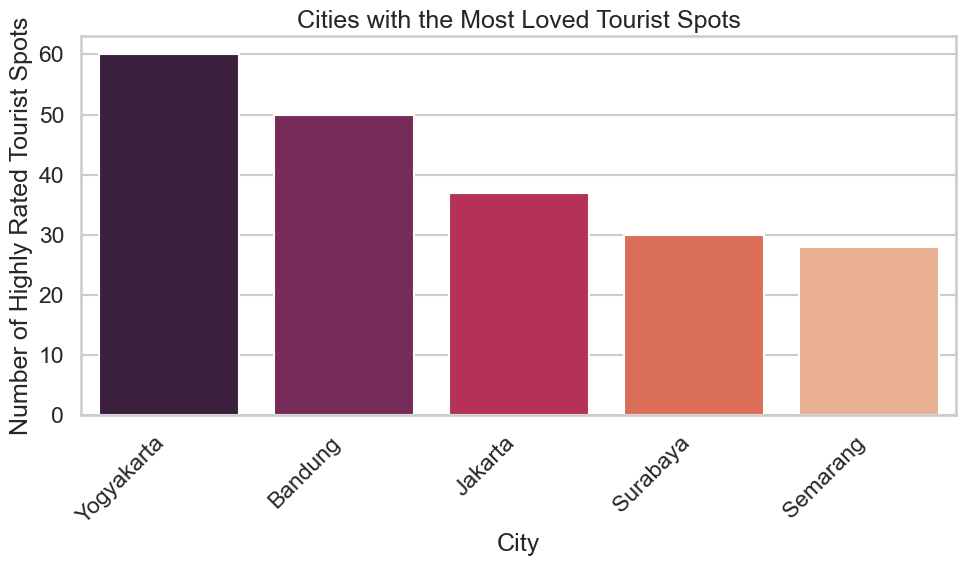

In [569]:
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(10, 6))

sns.barplot(
    x=city_love_counts.index,
    y=city_love_counts.values,
    palette="rocket"
)

plt.xlabel("City")
plt.ylabel("Number of Highly Rated Tourist Spots")
plt.title("Cities with the Most Loved Tourist Spots")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [571]:
best_city = city_love_counts.idxmax()
print("City with the most loved tourist spots:", best_city)

City with the most loved tourist spots: Yogyakarta


**Which Category of Places Are Users Liking the Most**

In [573]:
category_ratings = (
    tourism_ratings_df
    .groupby("Category")
    .agg(
        avg_rating=("Rating", "mean"),
        rating_count=("Rating", "count")
    )
    .reset_index()
)

In [575]:
category_ratings_sorted = category_ratings.sort_values(
    by="avg_rating",
    ascending=False
)

category_ratings_sorted

Category  avg_rating  rating_count
1              Budaya    4.528333          1380
3  Pusat Perbelanjaan    4.435985           264
4       Taman Hiburan    4.389856          1597
2          Cagar Alam    4.359651          1202
0              Bahari    4.290811           185

C:\Users\lenovo\AppData\Local\Temp\ipykernel_14024\25230718.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


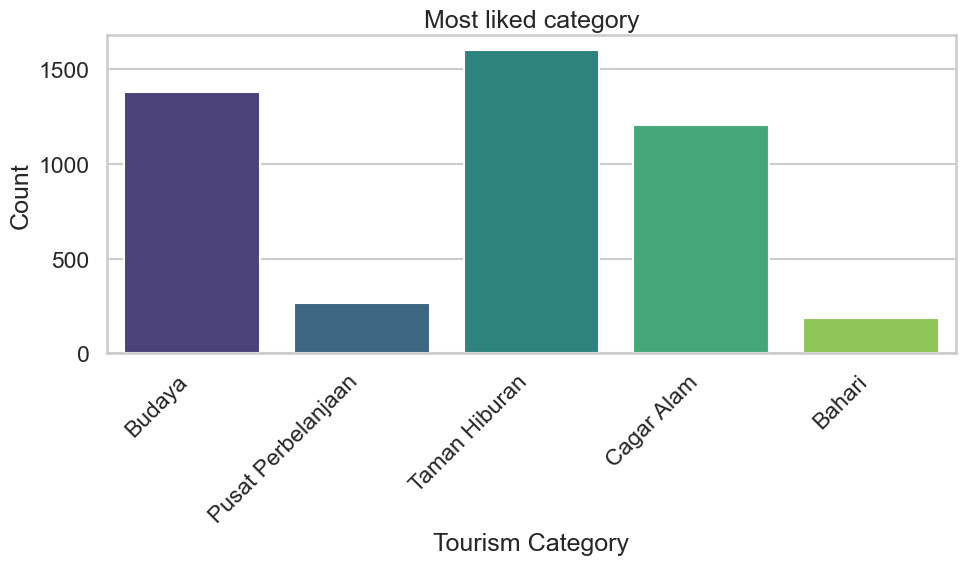

In [577]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=category_ratings_sorted[category_ratings_sorted['avg_rating']>=3.5],
    x="Category",
    y="rating_count",
    palette="viridis"
)

plt.xlabel("Tourism Category")
plt.ylabel("Count")
plt.title("Most liked category")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [579]:
most_liked_category = category_ratings_sorted.iloc[0]["Category"]
print("Most liked category by users:", most_liked_category)

Most liked category by users: Budaya


Tourist places and user ratings were combined to analyze user preferences. The most loved tourist spots were identified based on average ratings and rating volume, revealing the city with the highest concentration of highly rated attractions. Additionally, category-level analysis showed which types of tourist destinations are most preferred by users, offering valuable insights for personalized tourism recommendations and strategic tourism planning.

### Build a recommender model for the system
Use the above data to develop a collaborative filtering model for recommendation and 
use that to recommend other places to visit using the current tourist location (place 
name)

In [584]:
# Merge ratings with place details
tourism_ratings_df = ratings_df.merge(
    tourism_df,
    on="Place_Id",
    how="inner"
)

tourism_ratings_df.head()

User_Id  Place_Id  Place_Ratings                     Place_Name  \
0        1       179              3                Candi Ratu Boko   
1        1       344              2                  Pantai Marina   
2        1         5              5       Atlantis Water Adventure   
3        1       373              3         Museum Kereta Ambarawa   
4        1       101              4  Kampung Wisata Sosro Menduran   

                                         Description       Category  \
0  Situs Ratu Baka atau Candi Boko (Hanacaraka:Í¶...         Budaya   
1  Pantai Marina (bahasa Jawa: Í¶•Í¶±Í¶∂Í¶±Í¶∂Í¶Ç...         Bahari   
2  Atlantis Water Adventure atau dikenal dengan A...  Taman Hiburan   
3  Museum Kereta Api Ambarawa (bahasa Inggris: In...         Budaya   
4  Kampung wisata Sosromenduran merupakan kampung...         Budaya   

         City  Price  Rating  Time_Minutes  \
0  Yogyakarta  75000     4.6          90.0   
1    Semarang   3000     4.1           NaN   
2     Jakarta  94000     4.5          60.0   
3    Semarang  10000     4.5          60.0   
4  Yogyakarta      0     4.0           NaN   

                                        Coordinate       Lat        Long  
0          {'lat': -7.7705416, 'lng': 110.4894158} -7.770542  110.489416  
1           {'lat': -6.948877, 'lng': 110.3893285} -6.948877  110.389329  
2             {'lat': -6.12419, 'lng': 106.839134} -6.124190  106.839134  
3  {'lat': -7.264598899999997, 'lng': 110.4046017} -7.264599  110.404602  
4   {'lat': -7.792189999999999, 'lng': 110.362151} -7.792190  110.362151

**Create User–Place Rating Matrix**

In [589]:
user_place_matrix = tourism_ratings_df.pivot_table(
    index="User_Id",
    columns="Place_Name",
    values="Rating"
)

user_place_matrix.head()

Place_Name  Air Mancur Menari  Air Terjun Kali Pancur  \
User_Id                                                 
1                         NaN                     NaN   
2                         NaN                     NaN   
3                         NaN                     NaN   
4                         NaN                     NaN   
5                         NaN                     NaN   

Place_Name  Air Terjun Kedung Pedut  Air Terjun Semirang  \
User_Id                                                    
1                               NaN                  NaN   
2                               NaN                  NaN   
3                               NaN                  NaN   
4                               NaN                  NaN   
5                               NaN                  NaN   

Place_Name  Air Terjun Sri Gethuk  Alive Museum Ancol  \
User_Id                                                 
1                             NaN                 NaN   
2                             NaN                 NaN   
3                             NaN                 NaN   
4                             NaN                 NaN   
5                             NaN                 NaN   

Place_Name  Alun Alun Selatan Yogyakarta  Alun-Alun Kota Bandung  \
User_Id                                                            
1                                    NaN                     NaN   
2                                    NaN                     NaN   
3                                    NaN                     4.6   
4                                    NaN                     NaN   
5                                    NaN                     NaN   

Place_Name  Alun-alun Utara Keraton Yogyakarta  Amazing Art World  ...  \
User_Id                                                            ...   
1                                          NaN                NaN  ...   
2                                          NaN                NaN  ...   
3                                          NaN                NaN  ...   
4                                          NaN                NaN  ...   
5                                          NaN                NaN  ...   

Place_Name  Wisata Alam Wana Wisata Penggaron  Wisata Batu Kuda  \
User_Id                                                           
1                                         NaN               NaN   
2                                         NaN               NaN   
3                                         NaN               NaN   
4                                         NaN               NaN   
5                                         NaN               NaN   

Place_Name  Wisata Eling Bening  Wisata Kaliurang  \
User_Id                                             
1                           NaN               NaN   
2                           4.3               NaN   
3                           NaN               NaN   
4                           NaN               NaN   
5                           NaN               NaN   

Place_Name  Wisata Kampung Krisan Clapar  Wisata Kraton Jogja  \
User_Id                                                         
1                                    NaN                  NaN   
2                                    NaN                  NaN   
3                                    NaN                  NaN   
4                                    NaN                  NaN   
5                                    NaN                  NaN   

Place_Name  Wisata Kuliner Pecenongan  Wisata Lereng Kelir  \
User_Id                                                      
1                                 NaN                  NaN   
2                                 NaN                  4.3   
3                                 NaN                  NaN   
4                                 NaN                  NaN   
5                                 NaN                  NaN   

Place_Name  Wisata Mangrove Tapak  Wot Batu  
User

**Compute Place-to-Place Similarity**

In [592]:
from sklearn.metrics.pairwise import cosine_similarity

# Replace NaN values with 0 for similarity computation
user_place_filled = user_place_matrix.fillna(0)

# Compute cosine similarity between places
place_similarity = cosine_similarity(user_place_filled.T)

# Convert to DataFrame for easier handling
place_similarity_df = pd.DataFrame(
    place_similarity,
    index=user_place_filled.columns,
    columns=user_place_filled.columns
)

place_similarity_df.head()

Place_Name               Air Mancur Menari  Air Terjun Kali Pancur  \
Place_Name                                                           
Air Mancur Menari                 1.000000                0.000000   
Air Terjun Kali Pancur            0.000000                1.000000   
Air Terjun Kedung Pedut           0.177394                0.090909   
Air Terjun Semirang               0.000000                0.044455   
Air Terjun Sri Gethuk             0.062017                0.095346   

Place_Name               Air Terjun Kedung Pedut  Air Terjun Semirang  \
Place_Name                                                              
Air Mancur Menari                       0.177394             0.000000   
Air Terjun Kali Pancur                  0.090909             0.044455   
Air Terjun Kedung Pedut                 1.000000             0.044455   
Air Terjun Semirang                     0.044455             1.000000   
Air Terjun Sri Gethuk                   0.047673             0.000000   

Place_Name               Air Terjun Sri Gethuk  Alive Museum Ancol  \
Place_Name                                                           
Air Mancur Menari                     0.062017            0.000000   
Air Terjun Kali Pancur                0.095346            0.046524   
Air Terjun Kedung Pedut               0.047673            0.000000   
Air Terjun Semirang                   0.000000            0.000000   
Air Terjun Sri Gethuk                 1.000000            0.097590   

Place_Name               Alun Alun Selatan Yogyakarta  Alun-Alun Kota Bandung  \
Place_Name                                                                      
Air Mancur Menari                            0.055470                0.000000   
Air Terjun Kali Pancur                       0.042640                0.130558   
Air Terjun Kedung Pedut                      0.213201                0.087039   
Air Terjun Semirang                          0.166812                0.127688   
Air Terjun Sri Gethuk                        0.178885                0.045644   

Place_Name               Alun-alun Utara Keraton Yogyakarta  \
Place_Name                                                    
Air Mancur Menari                                  0.000000   
Air Terjun Kali Pancur                             0.103418   
Air Terjun Kedung Pedut                            0.000000   
Air Terjun Semirang                                0.000000   
Air Terjun Sri Gethuk                              0.054233   

Place_Name               Amazing Art World  ...  \
Place_Name                                  ...   
Air Mancur Menari                 0.177394  ...   
Air Terjun Kali Pancur            0.045455  ...   
Air Terjun Kedung Pedut           0.136364  ...   
Air Terjun Semirang               0.133366  ...   
Air Terjun Sri Gethuk             0.047673  ...   

Place_Name               Wisata Alam Wana Wisata Penggaron  Wisata Batu Kuda  \
Place_Name                                                                     
Air Mancur Menari                                 0.000000          0.000000   
Air Terjun Kali Pancur                            0.133366          0.055048   
Air Terjun Kedung Pedut                           0.000000          0.055048   
Air Terjun Semirang                               0.086957          0.000000   
Air Terjun Sri Gethuk                             0.046625          0.000000   

Place_Name               Wisata Eling Bening  Wisata Kaliurang  \
Place_Name                                                       
Air Mancur Menari                   0.110940          0.121046   
Air Terjun Kali Pancur              0.127920          0.093048   
Air Terjun Kedung Pedut             0.085280          0.093048   
Air Terjun Semirang                 0.125109          0.045502   
Air Terjun Sri Gethuk               0.134164          0.048795   

Place_Name               Wisata Kampung Krisan Clapar  Wisata Kraton Jogja  \
Place_Name                          

**Recommendation Function**

In [595]:
def recommend_similar_places(
    current_place,
    similarity_df,
    top_n=5
):
    if current_place not in similarity_df.index:
        raise ValueError("Place not found in the dataset")

    # Get similarity scores for the selected place
    similarity_scores = similarity_df[current_place]

    # Remove the place itself and sort by similarity
    recommendations = (
        similarity_scores
        .drop(labels=[current_place])
        .sort_values(ascending=False)
        .head(top_n)
    )

    return recommendations.reset_index().rename(
        columns={"index": "Recommended_Place", current_place: "Similarity_Score"}
    )

In [597]:
current_place = "Air Mancur Menari"  

recommended_places = recommend_similar_places(
    current_place=current_place,
    similarity_df=place_similarity_df,
    top_n=5
)

recommended_places

Place_Name  Similarity_Score
0  Museum De Javasche Bank          0.269069
1               Bukit Moko          0.242091
2                 Kota Tua          0.226455
3            Bukit Bintang          0.222375
4    Curug Tilu Leuwi Opat          0.221880

### CONCLUSION

A recommendation system was developed using tourist rating data to provide personalized place recommendations. By computing similarity between users based on their rating behavior, the system identifies tourists with similar preferences and recommends attractions that the target user has not yet visited. This approach effectively captures shared interests without relying on explicit user profiles.

The recommendation model enhances the tourism experience by helping travelers discover relevant destinations aligned with their tastes. From a broader perspective, such personalized recommendation systems support smarter tourism planning, encourage exploration of diverse attractions, and contribute to sustainable tourism growth by distributing visitor traffic more evenly across locations.